In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
import numpy as np
from darts.models import ExponentialSmoothing
from tasks_support_system_ai.utils import get_correct_data_path
from tasks_support_system_ai.readers import (
    ts_read_daily_tickets,
    read_ts_tree,
    get_map_parent_to_children_queues,
)

In [2]:
df = ts_read_daily_tickets(get_correct_data_path("tickets_daily/tickets_daily.csv"))
tree = read_ts_tree(get_correct_data_path("dataset_tickets_timeseries/tree_queue.tsv"))

# пропуски, частота, диапазон данных

In [3]:
df

,queueId,date,new_tickets
0,1,2017-01-01,15
1,1,2017-01-02,26
2,1,2017-01-03,25
3,1,2017-01-04,29
4,1,2017-01-05,26
...,...,...,...
418322,9,2020-08-30,1
418323,9,2020-09-13,1
418324,9,2020-09-16,1
418325,9,2020-09-17,1


In [4]:
df_grouped = (
    df.groupby("date").agg({"new_tickets": "sum"}).sort_values(by="date").reset_index()
)
df_grouped

,date,new_tickets
0,2017-01-01,1648
1,2017-01-02,2556
2,2017-01-03,3055
3,2017-01-04,3593
4,2017-01-05,3864
...,...,...
1364,2020-09-26,14960
1365,2020-09-27,16186
1366,2020-09-28,24743
1367,2020-09-29,27645


# Проверить аномалии данных

# наглядно показать тренд и сезональность

# Аналитика в разрезе очередей
А может ли быть такое, что когда-то стало слишком много тикетов из выпавших очередей?

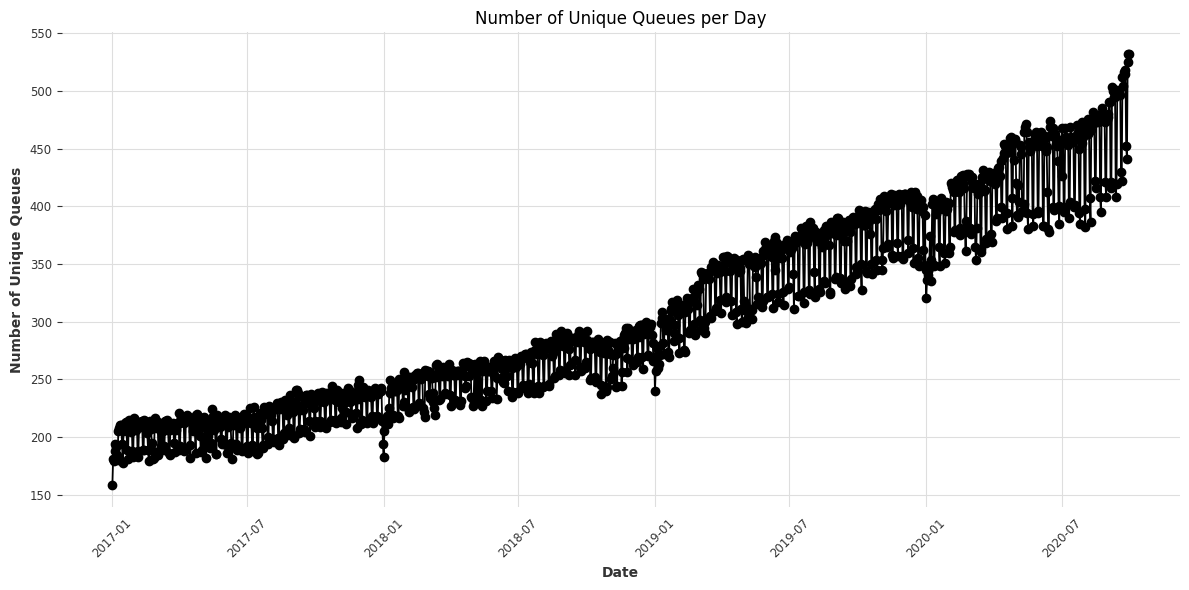

In [5]:
unique_queues = df.groupby("date")["queueId"].nunique().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(unique_queues["date"], unique_queues["queueId"], marker="o")
plt.title("Number of Unique Queues per Day")
plt.xlabel("Date")
plt.ylabel("Number of Unique Queues")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Есть ли связь между очередями (ниже пример топовых очередей, но лучше не проверять корреляцию родителя с потомком).

In [6]:
queue_to_all_children = get_map_parent_to_children_queues(tree)
size_queues = {}
for queue, children in queue_to_all_children.items():
    size_queues[queue] = df[df["queueId"].isin(children)].shape[0]
n = 10
top_queues = dict(sorted(size_queues.items(), key=lambda item: -item[1])[:n]).keys()
print(top_queues)

dict_keys([742, 1871, 115, 4447, 2641, 2002, 10, 4412, 34, 2610])


# Определить тестами сезональность, автокорреляцию, лаги

<Figure size 1500x600 with 0 Axes>

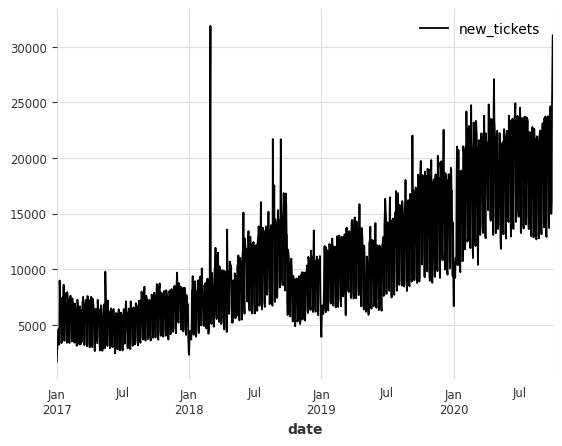

In [7]:
plt.figure(figsize=(15, 6))
df_grouped.plot(x="date", y="new_tickets")
plt.show()

In [8]:
import matplotlib.pyplot as plt
from darts.models import Prophet, Theta
from darts.metrics import mape
from darts.metrics import rmse

/var/folders/kn/8xhddqln3jb_nvkv79lkj0l00000gn/T/ipykernel_19028/3506771793.py:3: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_grouped["new_tickets_clipped"] = df_grouped["new_tickets"].clip(upper=upper_limit)


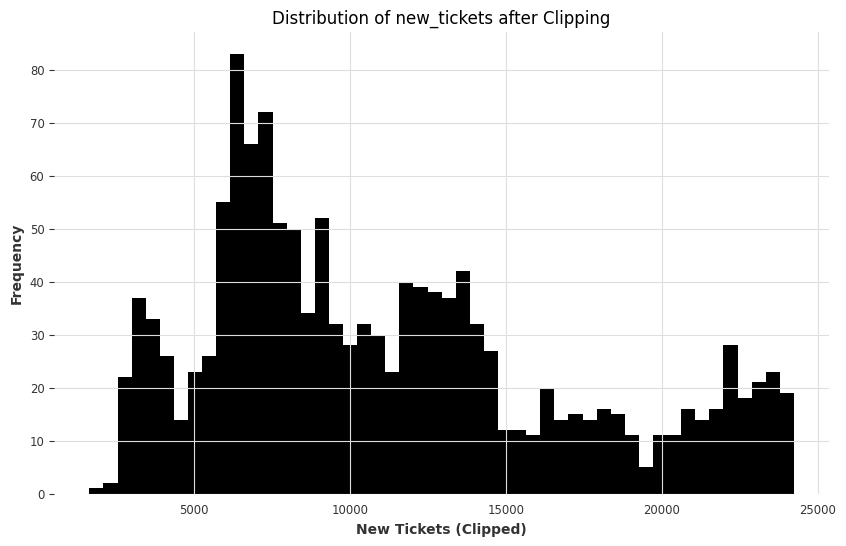

In [9]:
upper_limit = df_grouped["new_tickets"].quantile(0.99)

df_grouped["new_tickets_clipped"] = df_grouped["new_tickets"].clip(upper=upper_limit)

plt.figure(figsize=(10, 6))
df_grouped["new_tickets_clipped"].hist(bins=50)
plt.title("Distribution of new_tickets after Clipping")
plt.xlabel("New Tickets (Clipped)")
plt.ylabel("Frequency")
plt.show()


<Figure size 1500x600 with 0 Axes>

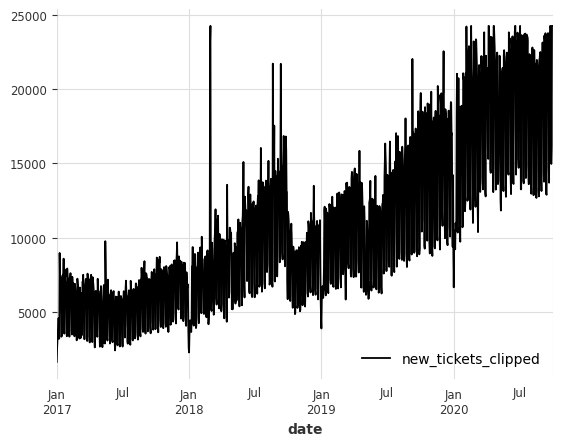

In [10]:
plt.figure(figsize=(15, 6))
df_grouped.plot(x="date", y="new_tickets_clipped")
plt.show()

Прологарифмируем значения

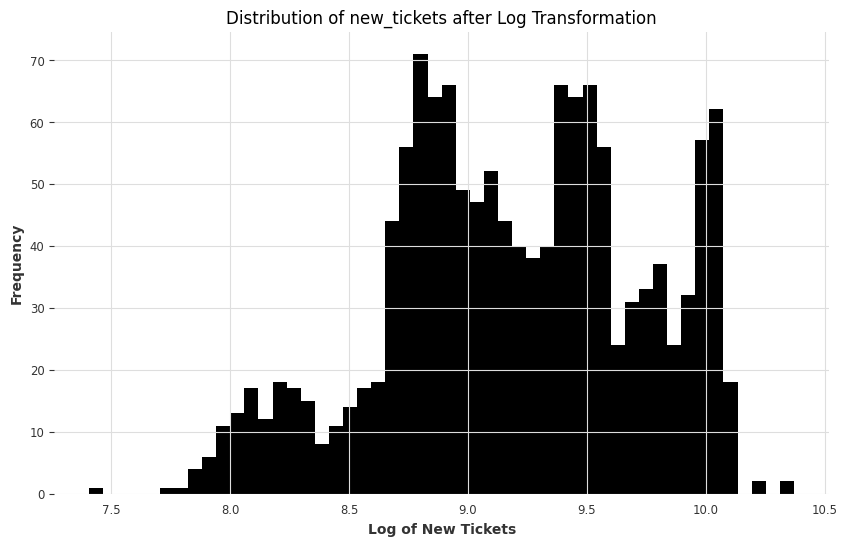

In [11]:
df_grouped["new_tickets_log"] = np.log(df_grouped["new_tickets"] + 1)

plt.figure(figsize=(10, 6))
df_grouped["new_tickets_log"].hist(bins=50)
plt.title("Distribution of new_tickets after Log Transformation")
plt.xlabel("Log of New Tickets")
plt.ylabel("Frequency")
plt.show()


<Figure size 1500x600 with 0 Axes>

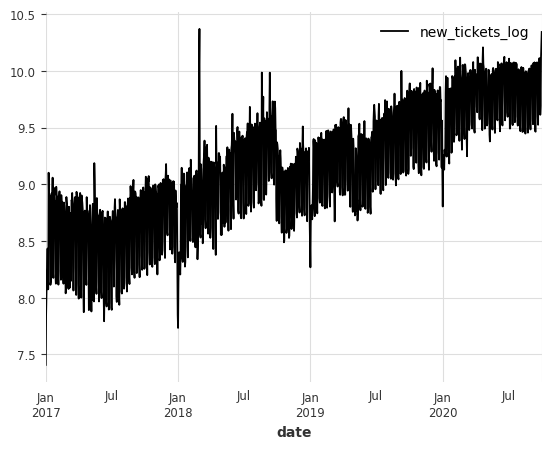

In [12]:
plt.figure(figsize=(15, 6))
df_grouped.plot(x="date", y="new_tickets_log")
plt.show()

# предлагаю предсказания вынести в отдельный файл

In [13]:
df_grouped

,date,new_tickets,new_tickets_clipped,new_tickets_log
0,2017-01-01,1648,1648,7.407924
1,2017-01-02,2556,2556,7.846590
2,2017-01-03,3055,3055,8.024862
3,2017-01-04,3593,3593,8.187021
4,2017-01-05,3864,3864,8.259717
...,...,...,...,...
1364,2020-09-26,14960,14960,9.613202
1365,2020-09-27,16186,16186,9.691964
1366,2020-09-28,24743,24241,10.116338
1367,2020-09-29,27645,24241,10.227236


Проверим значения за 2017 год

In [14]:
df_2017_2018 = df_grouped[df_grouped["date"] <= "2018.01.01"]
df_2017_2018

,date,new_tickets,new_tickets_clipped,new_tickets_log
0,2017-01-01,1648,1648,7.407924
1,2017-01-02,2556,2556,7.846590
2,2017-01-03,3055,3055,8.024862
3,2017-01-04,3593,3593,8.187021
4,2017-01-05,3864,3864,8.259717
...,...,...,...,...
361,2017-12-28,6885,6885,8.837246
362,2017-12-29,6455,6455,8.772765
363,2017-12-30,3777,3777,8.236950
364,2017-12-31,2566,2566,7.850493


<Figure size 1500x600 with 0 Axes>

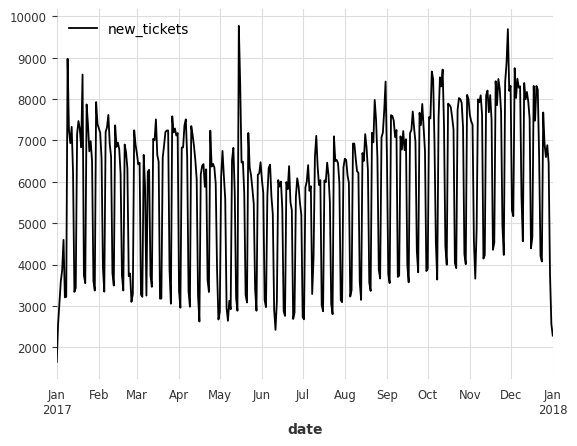

In [15]:
plt.figure(figsize=(15, 6))
df_2017_2018.plot(x="date", y="new_tickets")
plt.show()

Функция прогноза - передается датафрйем, столбец с количеством тикетов и модель для прогноза

In [16]:
def forecast(df, column, forecasting_model):
    series = TimeSeries.from_dataframe(df, "date", column, freq="D")

    print(f"Total data points: {len(series)}")

    training, validation = series.split_before(0.75)

    # print(f"Training data points: {len(training)}")
    # print(f"Validation data points: {len(validation)}")

    model = forecasting_model
    model.fit(training)

    n_pred = len(validation)
    pred = model.predict(n=n_pred)

    nan_in_forecast = pd.isna(pred.values()).any()

    if nan_in_forecast:
        print("The forecast contains NaN values. Model training may have failed.")
    else:
        rmse_error = rmse(validation, pred)
        mape_error = mape(validation, pred)

        print(f"RMSE: {rmse_error:.2f}")
        print(f"MAPE: {mape_error:.2f}")

        plt.figure(figsize=(15, 6))
        series.plot(label="Actual Data")
        pred.plot(label="Forecast")

        plt.title(f"Прогноз от {forecasting_model}")
        plt.legend()
        plt.show()

Total data points: 366
RMSE: 0.21
MAPE: 1.30


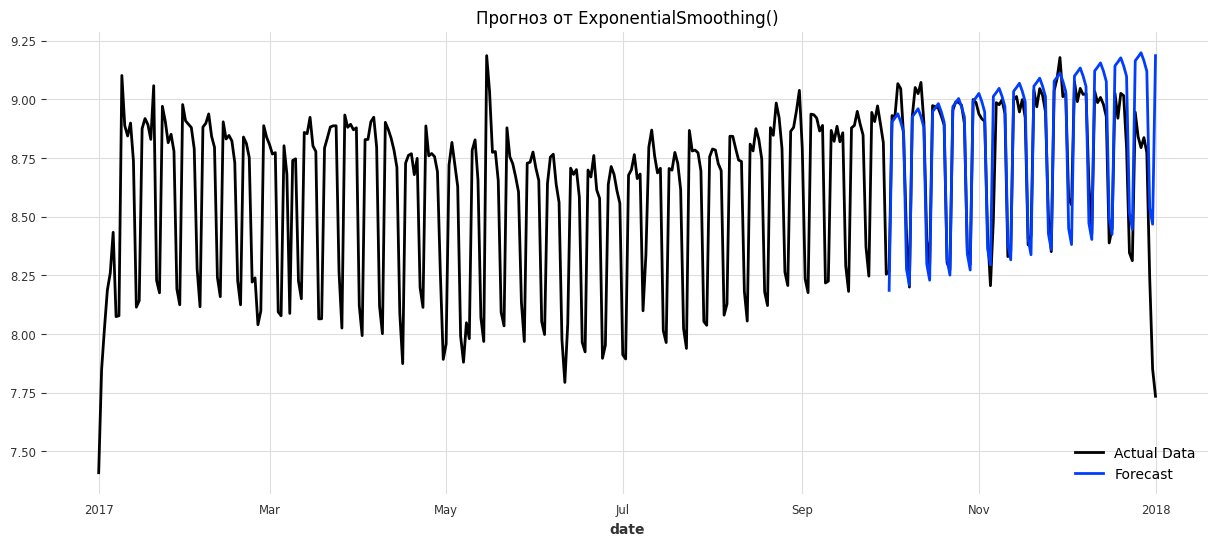

In [17]:
forecast(df_2017_2018, "new_tickets_log", ExponentialSmoothing())

Total data points: 366
RMSE: 996.70
MAPE: 12.86


/Users/pyro/github/tasks_support_system_ai/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


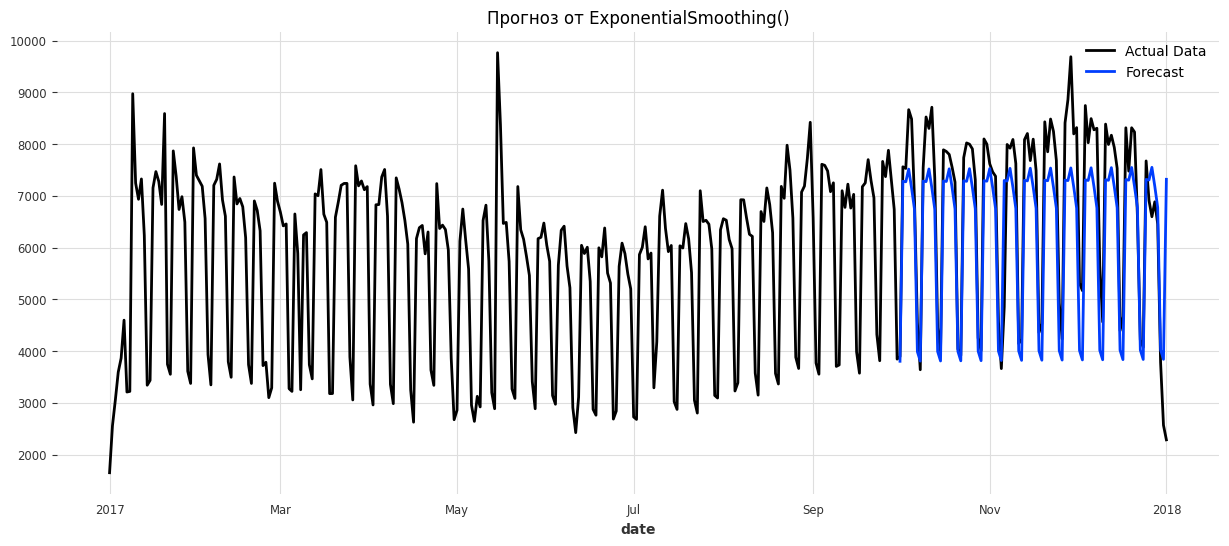

In [18]:
forecast(df_2017_2018, "new_tickets", ExponentialSmoothing())

Total data points: 366


22:35:39 - cmdstanpy - INFO - Chain [1] start processing
22:35:39 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.23
MAPE: 1.55


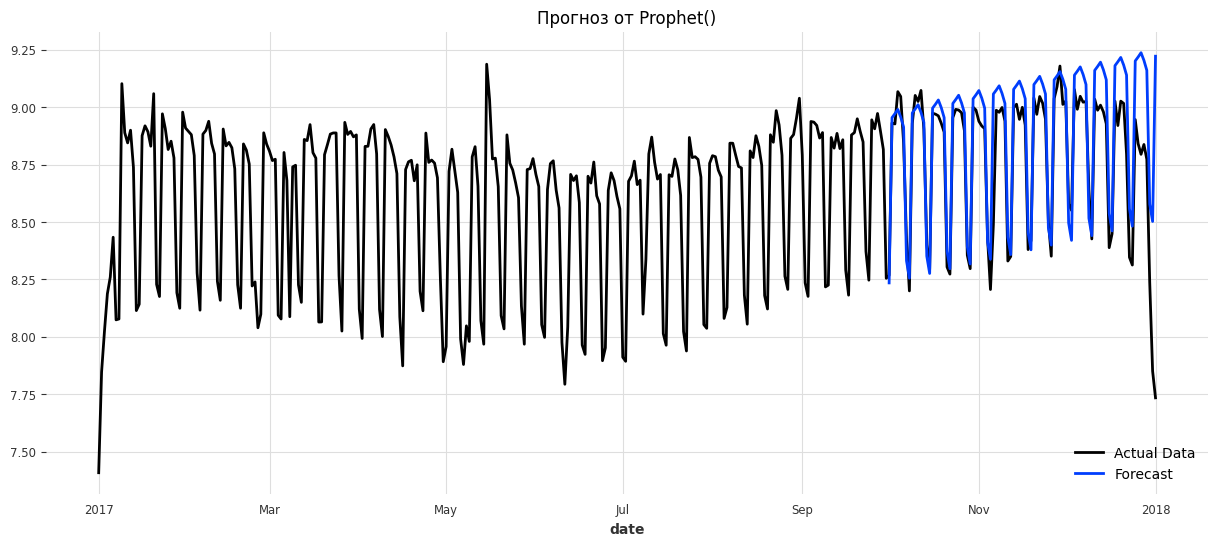

In [19]:
forecast(df_2017_2018, "new_tickets_log", Prophet())

22:35:39 - cmdstanpy - INFO - Chain [1] start processing
22:35:40 - cmdstanpy - INFO - Chain [1] done processing


Total data points: 366
RMSE: 948.80
MAPE: 11.02


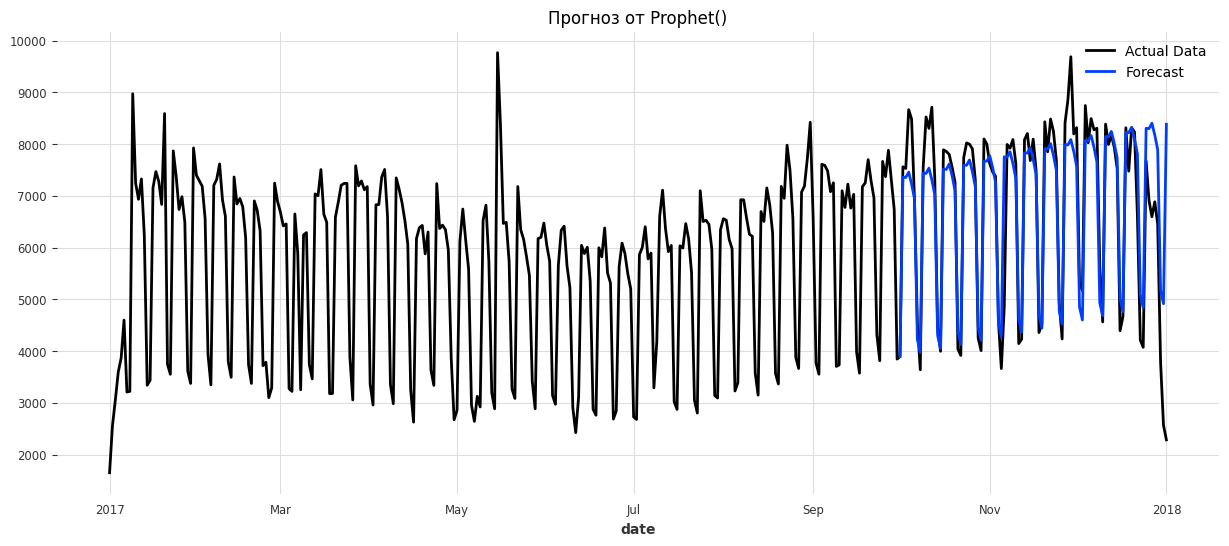

In [20]:
forecast(df_2017_2018, "new_tickets", Prophet())

Total data points: 366
RMSE: 0.18
MAPE: 1.41


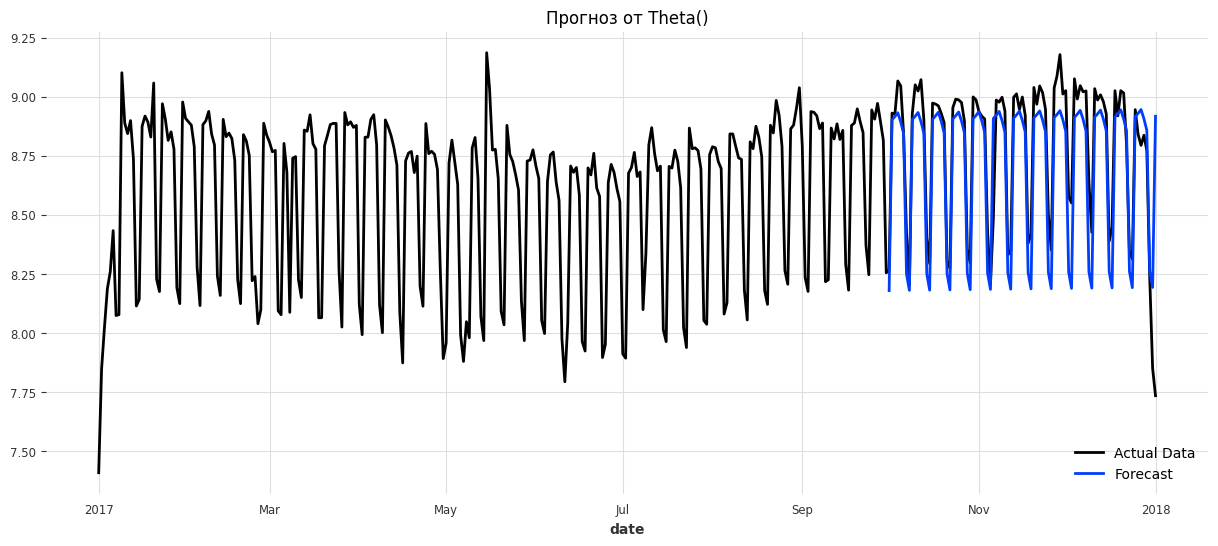

In [21]:
forecast(df_2017_2018, "new_tickets_log", Theta())

Total data points: 1369


22:35:40 - cmdstanpy - INFO - Chain [1] start processing
22:35:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.16
MAPE: 1.26


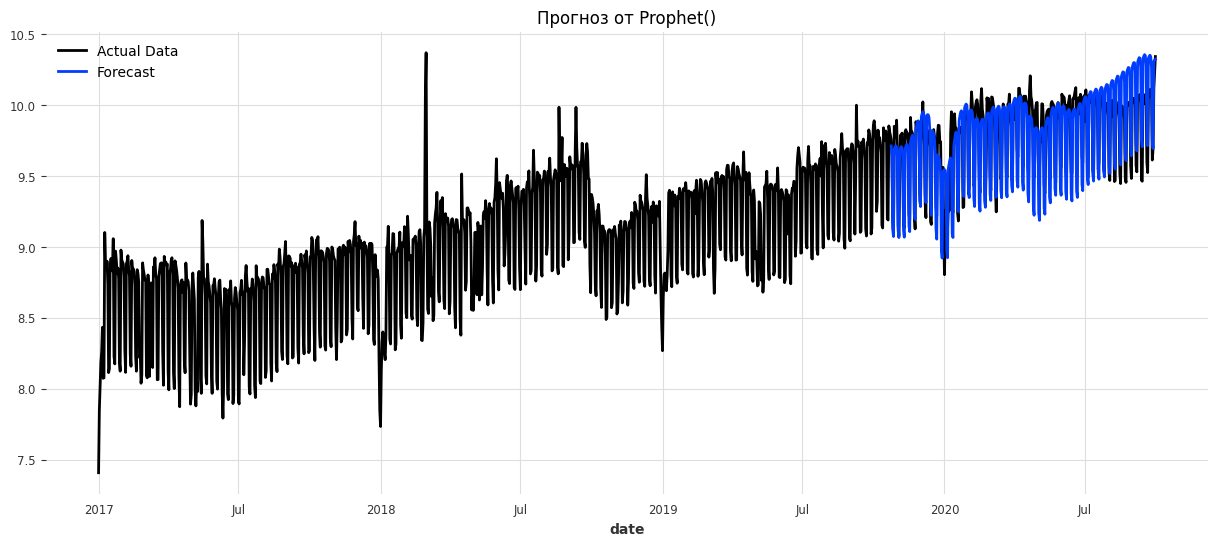

In [22]:
forecast(df_grouped, "new_tickets_log", Prophet())

22:35:41 - cmdstanpy - INFO - Chain [1] start processing
22:35:41 - cmdstanpy - INFO - Chain [1] done processing


Total data points: 1369
RMSE: 3220.52
MAPE: 14.23


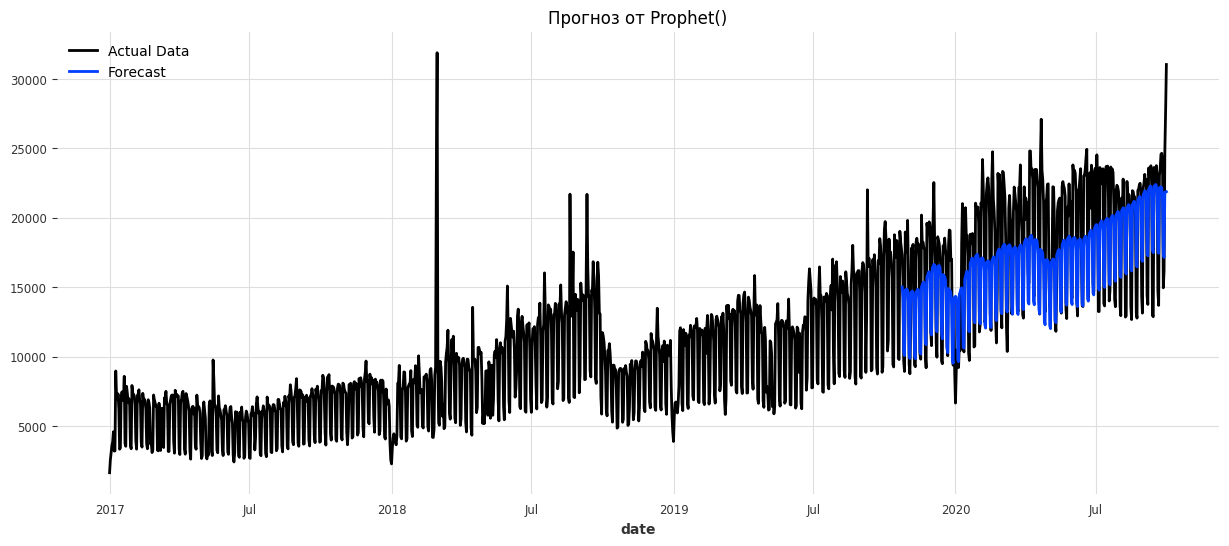

In [23]:
forecast(df_grouped, "new_tickets", Prophet())

Total data points: 1369
RMSE: 0.21
MAPE: 1.59


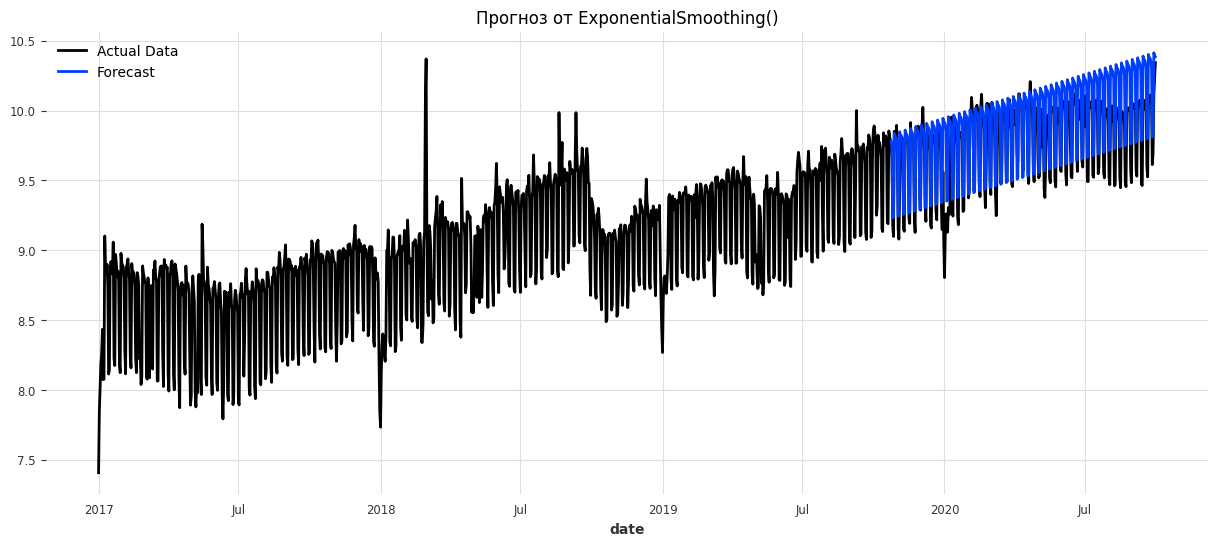

In [24]:
forecast(df_grouped, "new_tickets_log", ExponentialSmoothing())

Протестированы классические модели для прогнозирования временных рядов. Prophet , ES, Theta, Liner Reg, AutoArima. Prophet , ES, Theta показали себя лучше остальных. После применения логарифмирования rmse и mape значительно уменьшились